# Système d'attente Waterfall

## Modélisation du système Waterfall

Nous modélisons le système Waterfall de la manière suivante :

- Une file d'attente $F_1$ de paramètre $ M/M/K $ représentant l'attente pour les tests. La politique de service est FIFO.

- Une file d'attente $F_2$ de paramètre $ G/M/1 $ représentant l'attente pour l'envoie vers le front-end des résultats de la file précédente. L'entrée est de processus général G et non poisson M car $F_2$ prend en entrée les agents sortant de $F_1$, nous ne sommes donc pas sur un "vrai" processus de Poisson. La politique de service est FIFO.

Schématiquement, nous avons l'architecture suivante pour notre système d'attente

   [Entrée des agents] -> $F_1$ ($M/M/K$) -> $F_2$ ($G/M/1$) -> [Sortie des agents] 


Nous définissons de plus les paramètres suivants pour décrire le système:

- $ \lambda $: Taux d'arrivé des utilisateurs dans la file d'attente $ F_1 $, autrement dit dans le système d'attente Waterfall global (selon un processus de Poisson)
- $ \mu_1 $: Taux de service de la file d'attente $ F_1 $ (selon un processus de Poisson)
- $ \mu_2 $: Taux de service de la file d'attente $ F_2 $ (selon un processus de Poisson)
- $ K $: Nombres de serveurs pour la file d'attente $F_1$

Nous pouvons en déduire les taux de charge de $F_1$ et $F_2$:
- $\rho_1 = \frac{\lambda}{K * \mu_1}$
- $\rho_2 = \frac{\lambda}{\mu_2}$

Nous considérons en premier lieu que les files d'attentes ont une capacité infinie.

## Code Python de simulation

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
rng = np.random.default_rng()

class Wline():

    def __init__(self, size=None, policy=(lambda x: 0)):
        self.size = size
        self.next = policy
        self.queue = []

    def populate(self, queue):
        self.queue = queue
    
    def pop(self):
        pop_ix = self.next(self.queue)
        pop_val = None
        
        if -1 < pop_ix < len(self.queue):
            pop_val = self.queue[pop_ix]
            self.queue.pop(pop_ix)
            
        return pop_val

class InService():
    
    def __init__(self, nb=1, dist=None, depart_col='t_depart_sys'):
        self.nb = nb
        self.server = [None]*nb
        self.dist = dist
        self.depart_col = depart_col
        
    def full(self):
        return not (None in self.server)
        
    def leaving(self, tops):
        
        agent_id = None
        
        if not self.full():
            # Find first available server
            srv_ix = self.server.index(None) 
        
        else:
            # Extract agent with earliest departure in this stage
            agent_id = tops.loc[self.server, self.depart_col].astype(float).idxmin()
            srv_ix = self.server.index(agent_id)
        
        return srv_ix, agent_id

class Waterfall():
    
    def __init__(self,
                 arval_dist,
                 test_srv_dist,
                 front_srv_dist,
                 test_servers_nb,
                 front_servers_nb,
                 test_queue_size=None,
                 front_queue_size=None,
                 test_policy=lambda x: 0,
                 front_policy=lambda x: 0,
                 test_size=100,
                 backup=False,
                 backup_prob=1.0):

        # Distributions
        self.arval_dist = arval_dist
        self.test_srv_dist = test_srv_dist
        self.front_srv_dist = front_srv_dist
        
        # Servers and queue sizes
        self.test_servers_nb = test_servers_nb
        self.front_servers_nb = front_servers_nb
        
        self.test_queue_size = test_queue_size if test_queue_size else test_size
        self.front_queue_size = front_queue_size if front_queue_size else test_size
        
        #self.test_size = test_size + 1
        self.test_size = test_size

        # Waiting lines
        self.wline_test = Wline(size=test_queue_size, policy=test_policy)
        self.wline_front = Wline(size=front_queue_size, policy=front_policy)
        
        # Servers with correct departure field references
        self.test_inservice = InService(
            nb=test_servers_nb, 
            dist=test_srv_dist,
            depart_col='t_depart_test'
        )
        
        self.front_inservice = InService(
            nb=front_servers_nb, 
            dist=front_srv_dist,
            depart_col='t_depart_sys'
        )

        self.backup = backup
        self.backup_prob = backup_prob
        
        # Dataframe initialization
        column_names = [
            't_arval_test_queue',
            't_arval_test_srv',
            't_depart_test',
            't_arval_front_queue',
            't_arval_front_srv',
            't_depart_sys',
            'backed_up'
        ]
        
        self.tops = pd.DataFrame(
            np.empty((test_size, len(column_names)), dtype=object), 
            columns=column_names
        )
        
    # -------------------------------------------------
    def pretreat(self):
        """Generate arrival times for TEST queue."""
        t_inter = self.arval_dist(size=(self.test_size))
        self.tops.loc[0, 't_arval_test_queue'] = t_inter[0]
        
        for i in range(1, self.test_size):
            self.tops.loc[i, 't_arval_test_queue'] = \
                self.tops.loc[i-1, 't_arval_test_queue'] + t_inter[i]

    # -------------------------------------------------
    def run(self):
        """Simulate test queue → test servers → front queue → front servers."""
        self.wline_test.queue = [0]
        nxt = 1
        
        while nxt < self.test_size:
            agent = self.wline_test.pop()
            
            if agent is not None:
                # server arrival
                self.tops.loc[agent, 't_arval_test_srv'] = \
                    self.tops.loc[agent, 't_arval_test_queue']

                # find server
                srv_ix, dept_ag = self.test_inservice.leaving(self.tops)
                self.test_inservice.server[srv_ix] = agent

                # if server is busy, update arrival time
                if dept_ag is not None:
                    if self.tops.loc[agent, 't_arval_test_queue'] < \
                       self.tops.loc[dept_ag, 't_depart_test']:
                        self.tops.loc[agent, 't_arval_test_srv'] = \
                            self.tops.loc[dept_ag, 't_depart_test']

                # departure from test stage
                self.tops.loc[agent, 't_depart_test'] = \
                    self.tops.loc[agent, 't_arval_test_srv'] + self.test_inservice.dist()
            
            # evaluate admission of next arrival
            in_system = (self.tops.loc[0:nxt-1, 't_depart_test'] > 
                         self.tops.loc[nxt, 't_arval_test_queue']).sum()

            if self.test_queue_size is not None and \
               in_system >= self.test_queue_size + self.test_inservice.nb:
                # blocked at test
                self.tops.loc[nxt, 't_depart_test'] = -1
            else:
                self.wline_test.queue.append(nxt)

            nxt += 1
            
            # Gestion des backups (aléatoire ou systématique en fonction de backup_prob)
            if self.backup:
                self.tops.loc[agent, 'backed_up'] = \
                    np.random.default_rng().random() < self.backup_prob
            else:
                self.tops.loc[agent, 'backed_up'] = False
        
        # ==============================
        #     2. FRONT QUEUE STAGE
        # ==============================
        
        # -------------------------------------------------
        # Drain remaining agents in TEST queue
        while len(self.wline_test.queue) > 0:
            agent = self.wline_test.pop()
            if agent is None:
                break

            self.tops.loc[agent, 't_arval_test_srv'] = self.tops.loc[agent, 't_arval_test_queue']

            srv_ix, dept_ag = self.test_inservice.leaving(self.tops)
            self.test_inservice.server[srv_ix] = agent

            if dept_ag is not None:
                dept_time = self.tops.loc[dept_ag, 't_depart_test']
                if pd.notna(dept_time):
                    if self.tops.loc[agent, 't_arval_test_queue'] < dept_time:
                        self.tops.loc[agent, 't_arval_test_srv'] = dept_time

            self.tops.loc[agent, 't_depart_test'] = self.tops.loc[agent, 't_arval_test_srv'] + self.test_inservice.dist()

            
        entering = self.tops[self.tops['t_depart_test'] != -1].index
        if len(entering) == 0:
            return
        
        # Initialize
        entering = list(entering)
        first = entering[0]

        self.front_inservice.server = [None] * self.front_inservice.nb

        self.wline_front.queue = [first]
        self.tops.loc[first, 't_arval_front_queue'] = self.tops.loc[first, 't_depart_test']
        
        pos = 1
        
        while pos < len(entering):
            agent = self.wline_front.pop()
            
            if agent is not None:
                self.tops.loc[agent, 't_arval_front_srv'] = \
                    self.tops.loc[agent, 't_arval_front_queue']

                srv_ix, dept_ag = self.front_inservice.leaving(self.tops)
                self.front_inservice.server[srv_ix] = agent

                if dept_ag is not None:
                    if self.tops.loc[agent, 't_arval_front_queue'] < \
                       self.tops.loc[dept_ag, 't_depart_sys']:
                        self.tops.loc[agent, 't_arval_front_srv'] = \
                            self.tops.loc[dept_ag, 't_depart_sys']

                # final departure
                self.tops.loc[agent, 't_depart_sys'] = \
                    self.tops.loc[agent, 't_arval_front_srv'] + self.front_inservice.dist()

            
            next_agent = entering[pos]
            self.tops.loc[next_agent, 't_arval_front_queue'] = \
                self.tops.loc[next_agent, 't_depart_test']

            in_front = (self.tops.loc[entering[:pos], 't_depart_sys'] > 
                        self.tops.loc[next_agent, 't_arval_front_queue']).sum()

            if self.front_queue_size is not None and \
               in_front >= self.front_queue_size + self.front_inservice.nb:
                self.tops.loc[next_agent, 't_depart_sys'] = -1
            else:
                self.wline_front.queue.append(next_agent)

            pos += 1

        while len(self.wline_front.queue) > 0:
            agent = self.wline_front.pop()
            if agent is None:
                break

            self.tops.loc[agent, 't_arval_front_srv'] = self.tops.loc[agent, 't_arval_front_queue']

            srv_ix, dept_ag = self.front_inservice.leaving(self.tops)
            self.front_inservice.server[srv_ix] = agent

            if dept_ag is not None:
                dept_time = self.tops.loc[dept_ag, 't_depart_sys']
                if pd.notna(dept_time):
                    if self.tops.loc[agent, 't_arval_front_queue'] < dept_time:
                        self.tops.loc[agent, 't_arval_front_srv'] = dept_time

            self.tops.loc[agent, 't_depart_sys'] = self.tops.loc[agent, 't_arval_front_srv'] + self.front_inservice.dist()


    # -------------------------------------------------
    def posttreat(self):
        """Compute final stats and classify customers."""

        # Temporary dirty fix for last row of dataframe broken
        # TODO: fix it for real
        #self.tops = self.tops.iloc[:-1]
        
        # which customers were blocked
        self.tops['blocked_test'] = self.tops['t_depart_test'] == -1
        self.tops['blocked_front'] = (~self.tops['blocked_test']) & (self.tops['t_depart_sys'] == -1)
        self.tops['blocked_front_but_backup'] = (~self.tops['blocked_test']) & (self.tops['t_depart_sys'] == -1) & (self.tops['backed_up'] == True)
        self.tops['blocked_front_no_backup'] = (~self.tops['blocked_test']) & (self.tops['t_depart_sys'] == -1) & (self.tops['backed_up'] == False)
        self.tops['blocked'] = self.tops['blocked_test'] + self.tops['blocked_front']

        # arrival times may be missing for blocked front customers
        self.tops['t_depart_sys'] = (pd.to_numeric(self.tops['t_depart_sys'], errors='coerce').fillna(-1))
        self.tops['t_wait_test'] = np.where(
            self.tops['t_depart_test'] == -1, 
            0,
            self.tops['t_arval_test_srv'] - self.tops['t_arval_test_queue']
        )

        self.tops['t_wait_front'] = np.where(
            (self.tops['t_depart_sys'] == -1) | self.tops['blocked_test'],
            0,
            self.tops['t_arval_front_srv'] - self.tops['t_arval_front_queue']
        )

        self.tops['t_srv_test'] = np.where(
            self.tops['t_depart_test'] == -1, 
            0,
            self.tops['t_depart_test'] - self.tops['t_arval_test_srv']
        )

        self.tops['t_srv_front'] = np.where(
            self.tops['t_depart_sys'] == -1,
            0,
            self.tops['t_depart_sys'] - self.tops['t_arval_front_srv']
        )

        self.tops['t_sojourn'] = np.where(
            self.tops['t_depart_sys'] == -1, 
            0,
            self.tops['t_depart_sys'] - self.tops['t_arval_test_queue']
        )

        self.tops['t_sojourn_test'] = np.where(
            self.tops['t_depart_test'] == -1,
            0,
            self.tops['t_depart_test'] - self.tops['t_arval_test_queue']
        )

        self.tops['t_sojourn_front'] = np.where(
            (self.tops['t_depart_sys'] == -1) | self.tops['blocked_test'],
            0,
            self.tops['t_depart_sys'] - self.tops['t_arval_front_queue']
        )

    # -------------------------------------------------
    def timeline(self, t_delation=2):
        """Full-system timeline."""
        
        tmax = self.tops['t_depart_sys'].replace(-1, np.nan).max()
        t_range = np.linspace(0, tmax, t_delation * self.test_size)

        cols = [
            'in_test_queue', 'in_test_srv',
            'in_front_queue', 'in_front_srv',
            'in_system'
        ]

        timeline = pd.DataFrame(index=t_range, columns=cols)

        for t in t_range:
            timeline.loc[t, 'in_test_queue'] = \
                ((t >= self.tops['t_arval_test_queue']) &
                 (t <= self.tops['t_arval_test_srv'])).sum()

            timeline.loc[t, 'in_test_srv'] = \
                ((t >= self.tops['t_arval_test_srv']) &
                 (t <= self.tops['t_depart_test'])).sum()

            timeline.loc[t, 'in_front_queue'] = \
                ((t >= self.tops['t_arval_front_queue']) &
                 (t <= self.tops['t_arval_front_srv'])).sum()

            timeline.loc[t, 'in_front_srv'] = \
                ((t >= self.tops['t_arval_front_srv']) &
                 (t <= self.tops['t_depart_sys'])).sum()

            timeline.loc[t, 'in_system'] = \
                ((t >= self.tops['t_arval_test_queue']) &
                 (t <= self.tops['t_depart_sys'])).sum()

        stats = {
            'mean_waiting_time_test': self.tops['t_wait_test'].mean(),
            'mean_waiting_time_front': self.tops['t_wait_front'].mean(),
            'mean_service_time_test': self.tops['t_srv_test'].mean(),
            'mean_service_time_front': self.tops['t_srv_front'].mean(),
            'mean_sojourn_time_test': self.tops['t_sojourn_test'].mean(),
            'mean_sojourn_time_front': self.tops['t_sojourn_front'].mean(),
            'mean_sojourn_time': self.tops['t_sojourn'].mean(),
            'blocked_at_test': self.tops['blocked_test'].mean(),
            'blocked_at_front': self.tops['blocked_front'].mean(),
            'blocked_at_front_but_backup': self.tops['blocked_front_but_backup'].mean(),
            'blocked_at_front_no_backup': self.tops['blocked_front_no_backup'].mean(),
            'blocked_total': self.tops['blocked'].mean(),
            'test_busy_fraction': (timeline['in_test_srv'] == self.test_servers_nb).mean(),
            'front_busy_fraction': (timeline['in_front_srv'] == self.front_servers_nb).mean()
        }

        return timeline, pd.DataFrame.from_dict(stats, orient='index', columns=['value'])
    
    # -------------------------------------------------
    def simulate(self):
        self.pretreat()
        self.run()
        self.posttreat()

def plot_bench(bench):
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    # Define columns to plot
    counts = [
        'in_system',                        # total in system
        ['in_test_queue', 'in_front_queue'], # queues
        ['in_test_srv', 'in_front_srv']     # services
    ]

    labels = ['System', 'Queue', 'Service']
    colors = [
        ['black'],                     # total system
        ['blue', 'green'],             # test queue = blue, front queue = green
        ['red', 'orange']              # test service = red, front service = orange
    ]
    titles = ['Évolution du nombre total d\'agents dans le système', 'Évolution du nombre d\'agents en attente', 'Évolution du nombre d\'agents en service']

    for i in range(3):
        if isinstance(counts[i], list):
            # multiple lines
            for j, col in enumerate(counts[i]):
                bench.plot(y=col, use_index=True, ax=axes[i], linewidth=1.5,
                           drawstyle='steps-mid', color=colors[i][j],
                           label=col)
            axes[i].legend()
        else:
            # single line
            bench.plot(y=counts[i], use_index=True, ax=axes[i], linewidth=1.5,
                       drawstyle='steps-mid', color=colors[i][0])
        axes[i].set_title(titles[i])
        axes[i].set_ylabel(f'Agent number in {labels[i]}')
        axes[i].set_xlabel('Time')
        axes[i].set_ylim(0, max(bench['in_system']+1))

    plt.tight_layout()
    plt.show()


## Modèles théoriques
Nous définissons également des fonctions permettant de calculer les valeurs théoriques des métriques listées plus haut pour une file d'attente M/M/K et M/M/1. Cela nous permet de confronter nos résultats empiriques obtenus obtenus via simulation aux valeurs attendues.

In [73]:
def theoretical_mm1(arrival_rate, service_rate):
    """
    Computes theoretical expected metrics for a M/M/1 queue.
    """
    lamda = arrival_rate
    mu = service_rate
    rho = lamda / mu
    
    if rho >= 1:
        return {"stable": False, "rho": rho}
    
    # Mean sojourn time
    W = 1 / (mu - lamda)
    
    # Mean wait time in the queue (Little's formula)
    Wq = lamda / (mu * (mu - lamda))
    
    # Mean number of agents in the whole system
    L = lamda / (mu - lamda)
    
    # Mean number of agents waiting in queue
    Lq = lamda ** 2 / (mu * (mu - lamda))
    
    return {
        "stable": True,
        "mean_utilization_rate": rho,
        "p0": 1 - rho,
        "mean_agents_waiting": Lq,
        "mean_agents_total": L,
        "mean_sojourn_time": W,
        "mean_waiting_time": Wq
    }

def theoretical_mmk(arrival_rate, service_rate, num_servers):
    import math
    """
    Computes theoretical expected metrics for a M/M/K queue.
    If num_servers = 1, it is advised to use the theoretical_mm1 
    function instead for better and faster results.
    """
    lambdaa = arrival_rate
    mu = service_rate
    K = num_servers
    rho = lambdaa / (K * mu)
    
    if rho >= 1:
        return {"stable": False, "rho": rho}
    
    # Probability of having 0 agent
    sum_term = sum((K * rho) ** n / math.factorial(n) for n in range(K))
    last_term = ((K * rho) ** K / math.factorial(K)) * (1 / (1 - rho))
    p0 = 1 / (sum_term + last_term)
    
    # Waiting probability (Erlang-C)
    erlang_c = ((K * rho) ** K / math.factorial(K)) * (1 / (1 - rho)) * p0
    
    # Mean number of agents waiting in queue
    Lq = erlang_c * rho / (1 - rho)
    
    # Mean number of agents in the whole system
    L = Lq + K * rho

    # Mean wait time in the queue (Little's formula)
    Wq = Lq / lambdaa

    # Mean sojourn time
    W = L / lambdaa
    
    return {
        "stable": True,
        "mean_utilization_rate": rho,
        "p0": p0,
        "erlang_c": erlang_c,
        "mean_agents_waiting": Lq,
        "mean_agents_total": L,
        "mean_sojourn_time": W,
        "mean_waiting_time": Wq
    }

def theoretical_mmkc(arrival_rate, service_rate,  num_servers, capacity):
    """
    Computes theoretical expected metrics for a M/M/K/C queue.
    """
    lamda = arrival_rate
    mu = service_rate
    K = num_servers
    c = capacity
    r = lamda / mu
    rho = r / K
    
    # Probability of having 0 agent
    sum1 = sum(r**n / math.factorial(n) for n in range(K))
    
    if abs(rho - 1) < 1e-10:
        sum2 = (r**K / math.factorial(K)) * (c - K + 1)
    else:
        sum2 = (r**K / math.factorial(K)) * (1 - rho**(c - K + 1)) / (1 - rho)
    
    p0 = 1 / (sum1 + sum2)
    
    # Blocking probability
    if c >= K:
        p_blocking = (r**c / (math.factorial(K) * K**(c - K))) * p0
    else:
        p_blocking = (r**c / math.factorial(c)) * p0
    
    lambda_eff = lamda * (1 - p_blocking)
    
    # Mean number of agents in the whole system
    L = 0.0
    for n in range(c + 1):
        if n < K:
            pn = (r**n / math.factorial(n)) * p0
        else:
            pn = (r**n / (math.factorial(K) * K**(n - K))) * p0
        L += n * pn
    
    # Mean number of agents waiting in queue
    Lq = max(0, L - (lambda_eff / mu))
    
    if lambda_eff > 0:
        W = L / lambda_eff
        Wq = Lq / lambda_eff
    else:
        W = 0
        Wq = 0
    
    return {
        "mean_utilization_rate": rho,
        "p0": p0,
        "p_blocking": p_blocking,
        "mean_agents_waiting": Lq,
        "mean_agents_total": L,
        "lambda_eff": lambda_eff,
        "blocking_rate": p_blocking,
        "mean_sojourn_time": W,
        "mean_waiting_time": Wq
    }

# Analyse du système d'attente

Nous procédons maintenant à l'analyse du comportement du système d'attente Waterfall par le biais de simulations en jouant sur les paramètres.
Nous évaluons de plus la performance du système selon les métriques suivantes:
- Temps d'attente moyen (mean_waiting_time)
- Temps de service moyen (mean_service_time)
- Temps de séjour moyen (mean_sojourn_time)
- Proportion d'agents bloqués (blocked_at)
- Temps de saturation des serveurs (busy_fraction)

Chacune de nos simulations s'effectue sur un échantillon de 1000 agents pour garder des temps de calculs raisonnables.

## Cas avec files d'attentes infinies

On s'intéresse en premier lieu au système Waterfall en posant l'hypothèse que les deux files d'attentes $F_1$ et $F_2$ disposent d'une FIFO infinie. Il est donc impossible pour un agent de se voir rejeter l'accès à un des deux files du système d'attente.

### Première simulation: cas stable
Nous effectuons une première simulation avec les paramètres suivants:
- $ \lambda $ = 4
- $ \mu_1 $ = 2
- $ \mu_2 $ = 6
- $ K $ = 3

Ayant $\lambda$ < $K * \mu_1$ et $\lambda$ < $\mu_2$, nous nous attendons à voir une stabilité du système global, car le taux d'entrée des agents est inférieur au taux de service des deux files d'attentes $F_1$ et $F_2$ de notre système d'attente.

Nous avons en effet un taux de charge pour $F_1$: $\rho_1 = \frac{\lambda}{K * \mu_1} < 1$

De même pour $F_2$: $\rho_2 = \frac{\lambda}{\mu_2} < 1$


In [74]:
# Waiting system parameters
lambdaa = 4.
mu_1 = 2.
mu_2 = 6.
k = 3

arval_dist = lambda size : rng.exponential(1./lambdaa, size=size)
test_srv_dist = lambda : rng.exponential(1./mu_1)
front_srv_dist = lambda : rng.exponential(1./mu_2)

fifo_policy = lambda x: 0

agent_nb = 1000

waterfall = Waterfall(arval_dist,
                 test_srv_dist,
                 front_srv_dist,
                 k,
                 1,
                 test_queue_size=None,
                 front_queue_size=None,
                 test_policy=fifo_policy,
                 front_policy=fifo_policy,
                 test_size=agent_nb)

theo_f1 = theoretical_mmk(lambdaa, mu_1, k)
theo_f2 = theoretical_mm1(lambdaa, mu_2)
theo_f1, theo_f2

({'stable': True,
  'mean_utilization_rate': 0.6666666666666666,
  'p0': 0.1111111111111111,
  'erlang_c': 0.4444444444444443,
  'mean_agents_waiting': 0.8888888888888884,
  'mean_agents_total': 2.8888888888888884,
  'mean_sojourn_time': 0.7222222222222221,
  'mean_waiting_time': 0.2222222222222221},
 {'stable': True,
  'mean_utilization_rate': 0.6666666666666666,
  'p0': 0.33333333333333337,
  'mean_agents_waiting': 1.3333333333333333,
  'mean_agents_total': 2.0,
  'mean_sojourn_time': 0.5,
  'mean_waiting_time': 0.3333333333333333})

In [75]:
waterfall.simulate()
bench, stats = waterfall.timeline()
stats

,value
mean_waiting_time_test,0.275385
mean_waiting_time_front,0.829531
mean_service_time_test,0.501156
mean_service_time_front,0.164929
mean_sojourn_time_test,0.776541
mean_sojourn_time_front,0.994460
mean_sojourn_time,1.771001
blocked_at_test,0.000000
blocked_at_front,0.000000
blocked_at_front_but_backup,0.000000


In [31]:
#plot_bench(bench)
waterfall.tops

,t_arval_test_queue,t_arval_test_srv,t_depart_test,t_arval_front_queue,t_arval_front_srv,t_depart_sys,blocked_test,blocked_front,blocked,t_wait_test,t_wait_front,t_srv_test,t_srv_front,t_sojourn,t_sojourn_test,t_sojourn_front
0,0.248054,0.248054,0.867995,0.867995,0.867995,0.956190,False,False,False,0.0,0.0,0.619941,0.088194,0.708135,0.619941,0.088194
1,0.539695,0.539695,1.917219,1.917219,1.917219,2.306762,False,False,False,0.0,0.0,1.377524,0.389543,1.767067,1.377524,0.389543
2,0.707238,0.707238,0.778141,0.778141,2.306762,2.440780,False,False,False,0.0,1.528621,0.070903,0.134018,1.733541,0.070903,1.662638
3,0.943981,0.943981,2.497596,2.497596,2.497596,2.910761,False,False,False,0.0,0.0,1.553615,0.413165,1.966781,1.553615,0.413165
4,1.036831,1.036831,1.300799,1.300799,2.910761,2.927627,False,False,False,0.0,1.609963,0.263967,0.016866,1.890796,0.263967,1.626829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,253.682433,253.682433,253.748578,253.748578,254.480333,254.614227,False,False,False,0.0,0.731755,0.066145,0.133894,0.931794,0.066145,0.865649
996,253.980303,253.980303,254.045573,254.045573,254.614227,254.863035,False,False,False,0.0,0.568653,0.065271,0.248808,0.882732,0.065271,0.817461
997,254.187737,254.187737,254.862523,254.862523,254.863035,255.019235,False,False,False,0.0,0.000511,0.674786,0.156201,0.831499,0.674786,0.156712
998,254.764894,254.764894,254.96623,254.96623,255.019235,255.058659,False,False,False,0.0,0.053006,0.201335,0.039423,0.293764,0.201335,0.092429


Selon les graphiques plus haut, nous observons effectivement la stabilité du système au global. 

Le premier graphique nous montre que le nombre maximum d'agents dans le système converge bien vers une valeur entière et qu'il n'y a pas d'"explosion" des files d'attentes s'accumulant sur le temps (les pics finissent toujours par redescendre).

Le deuxième graphique nous montre plus en détail l'occupation des files d'attentes, nous pouvons observer que la file d'attente de $F_1$ (courbe 'in_test_queue') n'est jamais occupée, ce qui montre qu'elle ne souffre d'aucun goulot d'étranglement de par le faible nombre d'arrivés d'agents par rapport au taux de service et au nombre de serveur K.

La file d'attente de $F_2$ en revanche contient significativement plus d'agents en attente, ce qui est logique compte tenue du fait qu'elle ne dispose que d'un seul serveur de traitement et qu'elle prend en entrée les sorties de la file $F_2$ disposant d'un taux de service naturellement plus élevé car disposant de $K$ serveurs.

### Deuxième simulation: instabilité de la file $F_1$
Nous effectuons une deuxième simulation avec les paramètres suivants:
- $ \lambda $ = 8
- $ \mu_1 $ = 2
- $ \mu_2 $ = 10
- $ K $ = 3

Ici l'objectif est d'observer le comportement du système dans le cas où la première file $F_1$ agit comme un goulot d'étranglement évident. Cela se traduit par le fait d'avoir $K* \mu_1 \leq \lambda$.

Autrement dit, le taux de charge de la file $F_1$ $\rho_1 = \frac{\lambda}{K * \mu_1}$ devient supérieur ou égal à 1.

In [12]:
# Waiting system parameters
lambdaa = 8.
mu_1 = 2.
mu_2 = 10.
k = 3

arval_dist = lambda size : rng.exponential(1./lambdaa, size=size)
test_srv_dist = lambda : rng.exponential(1./mu_1)
front_srv_dist = lambda : rng.exponential(1./mu_2)

fifo_policy = lambda x: 0

agent_nb = 1000

waterfall = Waterfall(arval_dist,
                 test_srv_dist,
                 front_srv_dist,
                 k,
                 1,
                 test_queue_size=None,
                 front_queue_size=None,
                 test_policy=fifo_policy,
                 front_policy=fifo_policy,
                 test_size=agent_nb)

theo_f1 = theoretical_mmk(lambdaa, mu_1, k)
theo_f2 = theoretical_mm1(lambdaa, mu_2)
theo_f1, theo_f2

({'stable': False, 'rho': 1.3333333333333333},
 {'stable': True,
  'mean_utilization_rate': 0.8,
  'p0': 0.19999999999999996,
  'mean_agents_waiting': 3.2,
  'mean_agents_total': 4.0,
  'mean_sojourn_time': 0.5,
  'mean_waiting_time': 0.4})

In [13]:
waterfall.simulate()
bench, stats = waterfall.timeline()
stats

,value
mean_waiting_time_test,19.089762
mean_waiting_time_front,0.872793
mean_service_time_test,0.511793
mean_service_time_front,0.101832
mean_sojourn_time_test,19.601555
mean_sojourn_time_front,0.974624
mean_sojourn_time,20.576180
blocked_at_test,0.000000
blocked_at_front,0.000000
blocked_total,0.000000


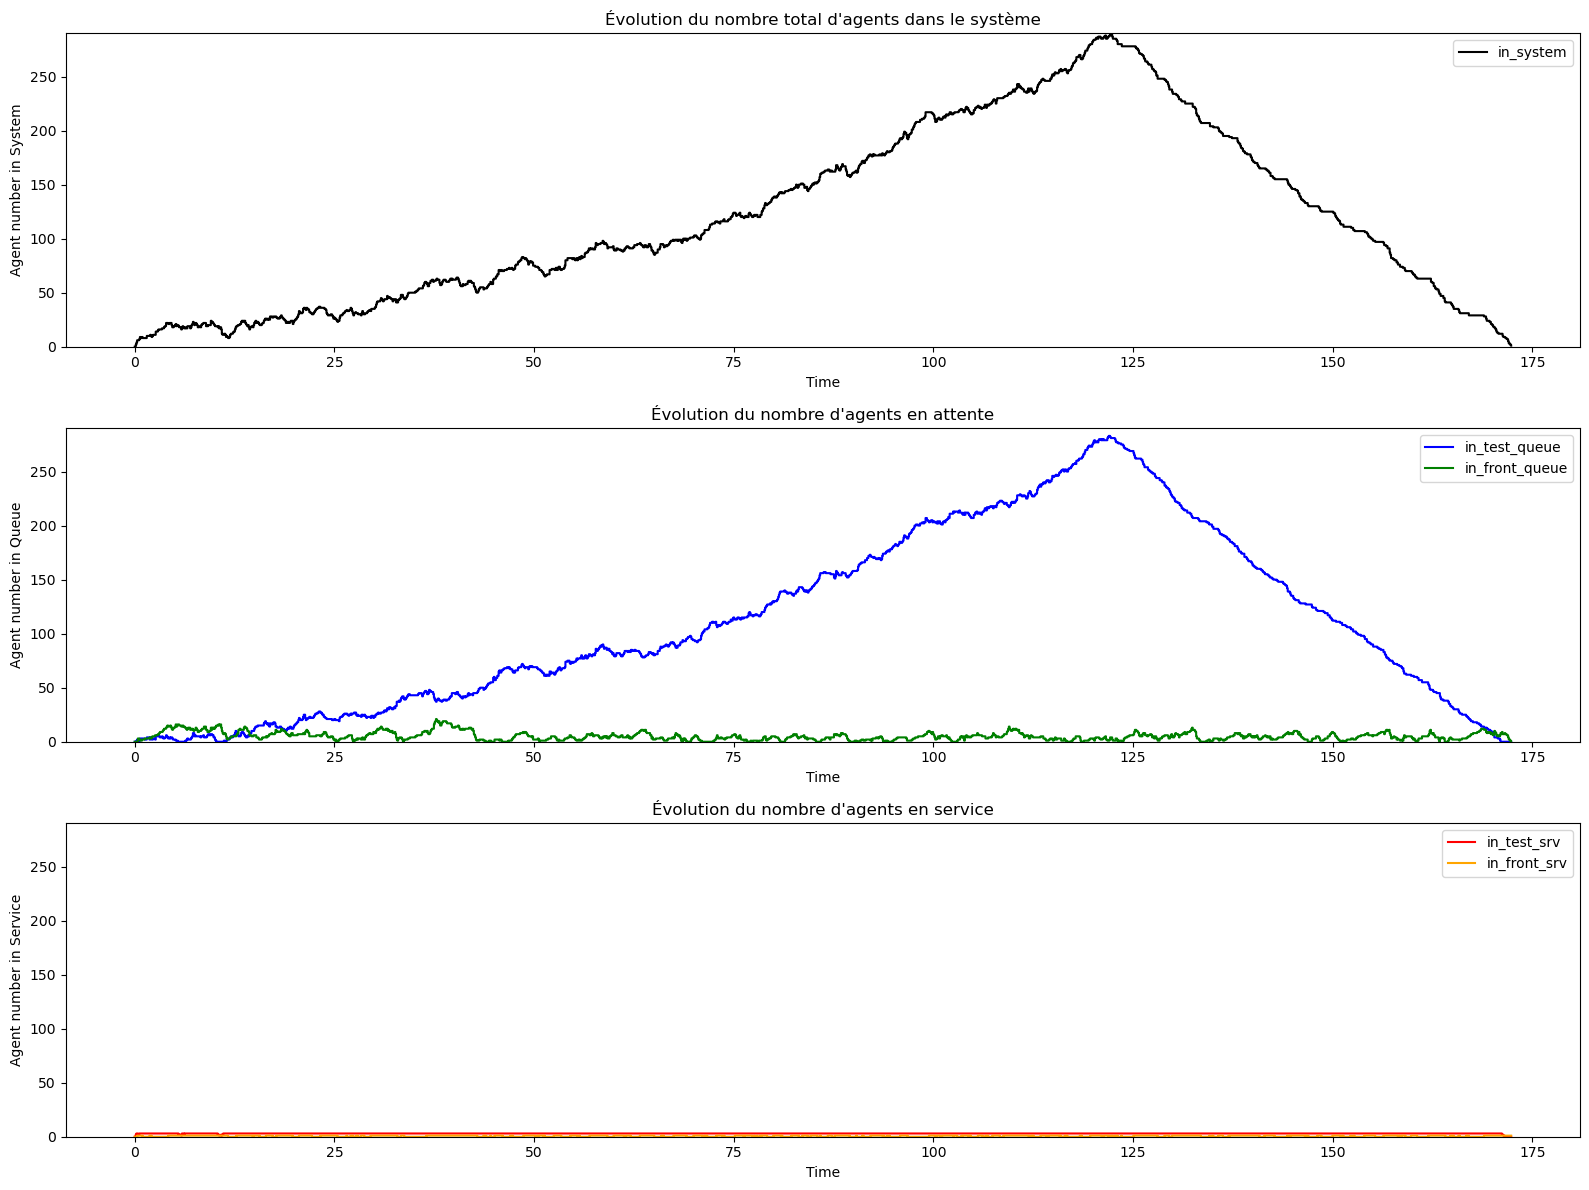

In [14]:
plot_bench(bench)

Cette fois-ci on observe plus de "pics" réguliers mais une accumulation graduelle qui finit éventuellement par redescendre de par le nombre d'agent limité dans le cadre de la simulation. Ce pic correspond à l'"explosion" de la file $F_1$, et si notre simulation était infinie ce pic divergerait vers l'infini, ce qui montre bien l'instabilité de la file $F_1$.

On voit bien que c'est $F_1$ qui explose par le biais du deuxiême graphe, où la courbe bleue montre les agents en attente dans $F_1$.

Ce cas peut être interprété par le fait d'avoir trop d’étudiants qui lancent des tests par rapport à la capacité du système de moulinettage.

### Troisième simulation: instabilité de la file $F_2$
Nous effectuons une troisième simulation avec les paramètres suivants:
- $ \lambda $ = 8
- $ \mu_1 $ = 2
- $ \mu_2 $ = 6
- $ K $ = 5

Ici l'objectif est d'observer le comportement du système dans le cas où la deuxième file $F_2$ agit comme un goulot d'étranglement évident. Cela se traduit par le fait d'avoir $K* \mu_1 > \lambda$ et $\mu_2 < \lambda$.

Autrement dit, le taux de charge de la file $F_1$ $\rho_1 = \frac{\lambda}{K * \mu_1}$ est bien inférieur à 1, mais le taux de charge de la file $F_2$ $\rho_2 = \frac{\lambda}{\mu_2}$ est supérieur à 1.

Note: par soucis de simplicité nous considérons que la file $F_2$ a un processus de Poisson en entrée, mais c'est techniquement pas une loi de Poisson "pure" car l'entrée de $F_2$ correspond à la sortie de $F_1$.

In [6]:
# Waiting system parameters
lambdaa = 8.
mu_1 = 2.
mu_2 = 6.
k = 5

arval_dist = lambda size : rng.exponential(1./lambdaa, size=size)
test_srv_dist = lambda : rng.exponential(1./mu_1)
front_srv_dist = lambda : rng.exponential(1./mu_2)

agent_nb = 1000

fifo_policy = lambda x: 0

waterfall = Waterfall(arval_dist,
                 test_srv_dist,
                 front_srv_dist,
                 k,
                 1,
                 test_queue_size=None,
                 front_queue_size=None,
                 test_policy=fifo_policy,
                 front_policy=fifo_policy,
                 test_size=agent_nb)

theo_f1 = theoretical_mmk(lambdaa, mu_1, k)
theo_f2 = theoretical_mm1(lambdaa, mu_2)
theo_f1, theo_f2

({'stable': True,
  'mean_utilization_rate': 0.8,
  'p0': 0.012987012987012988,
  'erlang_c': 0.5541125541125542,
  'mean_agents_waiting': 2.2164502164502173,
  'mean_agents_total': 6.216450216450218,
  'mean_sojourn_time': 0.7770562770562772,
  'mean_waiting_time': 0.27705627705627717},
 {'stable': False, 'rho': 1.3333333333333333})

In [16]:
waterfall.simulate()
bench, stats = waterfall.timeline()
stats

,value
mean_waiting_time_test,0.161386
mean_waiting_time_front,22.200002
mean_service_time_test,0.483028
mean_service_time_front,0.168861
mean_sojourn_time_test,0.644414
mean_sojourn_time_front,22.368863
mean_sojourn_time,23.013277
blocked_at_test,0.000000
blocked_at_front,0.000000
blocked_total,0.000000


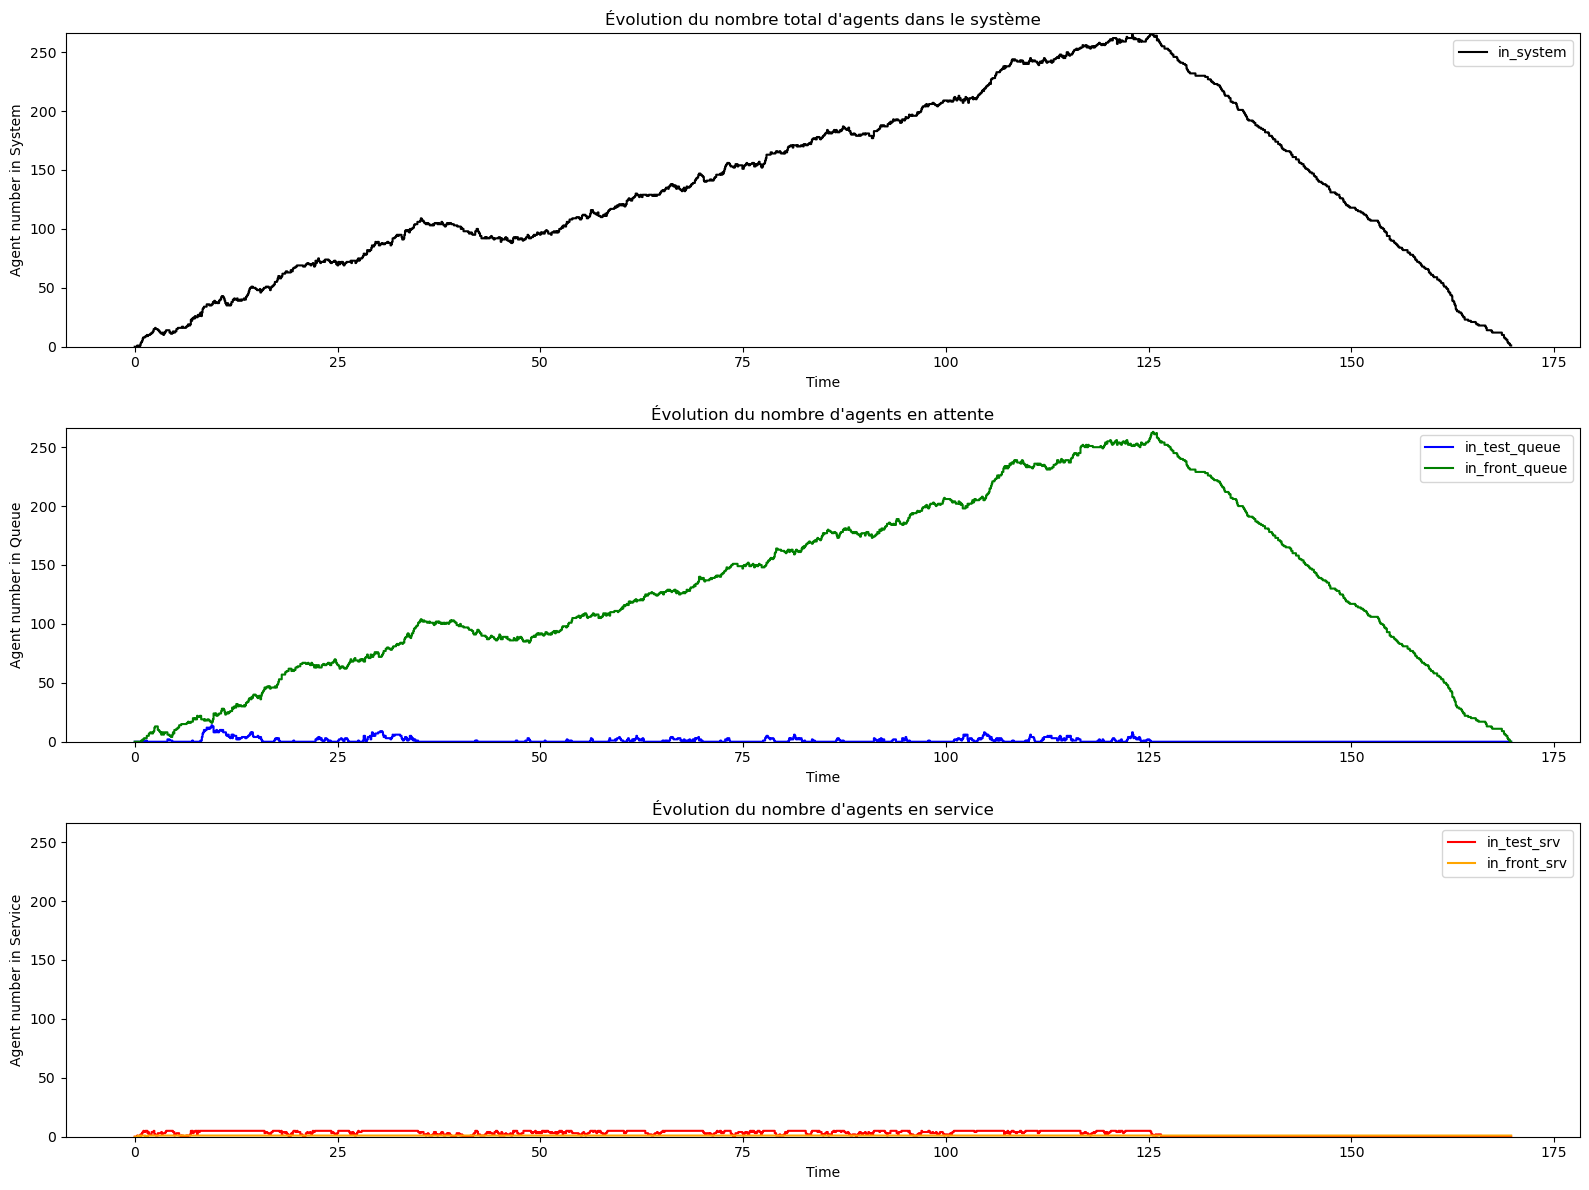

In [17]:
plot_bench(bench)

On observe un comportement similaire à la simulation précédente, sauf que cette fois il s'agit de file d'attente $F_2$ (courbe verte) qui explose.

Ce cas peut être interprété par le fait d'avoir une capacité d'envoi vers le front-end insuffisante par rapport à la capacité de traitement des tests.

### Quatrième simulation: frontière de stabilité
Nous effectuons une dernière simulation avec les paramètres suivants:
- $ \lambda $ = 6
- $ \mu_1 $ = 2
- $ \mu_2 $ = 6
- $ K $ = 3

Ici l'objectif est d'observer le comportement du système dans le cas à la limite de stabilité des deux files d'attente.
Autrement dit, le taux de charge de la file $F_1$: $\rho_1 = \frac{\lambda}{K * \mu_1}$ est égal à 1, et le taux de charge de la file $F_2$: $\rho_2 = \frac{\lambda}{\mu_2}$ est égal à 1.

In [18]:
# Waiting system parameters
lambdaa = 6.
mu_1 = 2.
mu_2 = 6.
k = 3

arval_dist = lambda size : rng.exponential(1./lambdaa, size=size)
test_srv_dist = lambda : rng.exponential(1./mu_1)
front_srv_dist = lambda : rng.exponential(1./mu_2)

agent_nb = 1000

fifo_policy = lambda x: 0

waterfall = Waterfall(arval_dist,
                 test_srv_dist,
                 front_srv_dist,
                 k,
                 1,
                 test_queue_size=None,
                 front_queue_size=None,
                 test_policy=fifo_policy,
                 front_policy=fifo_policy,
                 test_size=agent_nb)

theo_f1 = theoretical_mmk(lambdaa, mu_1, k)
theo_f2 = theoretical_mm1(lambdaa, mu_2)
theo_f1, theo_f2

({'stable': False, 'rho': 1.0}, {'stable': False, 'rho': 1.0})

In [19]:
waterfall.simulate()
bench, stats = waterfall.timeline()
stats

,value
mean_waiting_time_test,1.605940
mean_waiting_time_front,3.076640
mean_service_time_test,0.491766
mean_service_time_front,0.169330
mean_sojourn_time_test,2.097706
mean_sojourn_time_front,3.245970
mean_sojourn_time,5.343676
blocked_at_test,0.000000
blocked_at_front,0.000000
blocked_total,0.000000


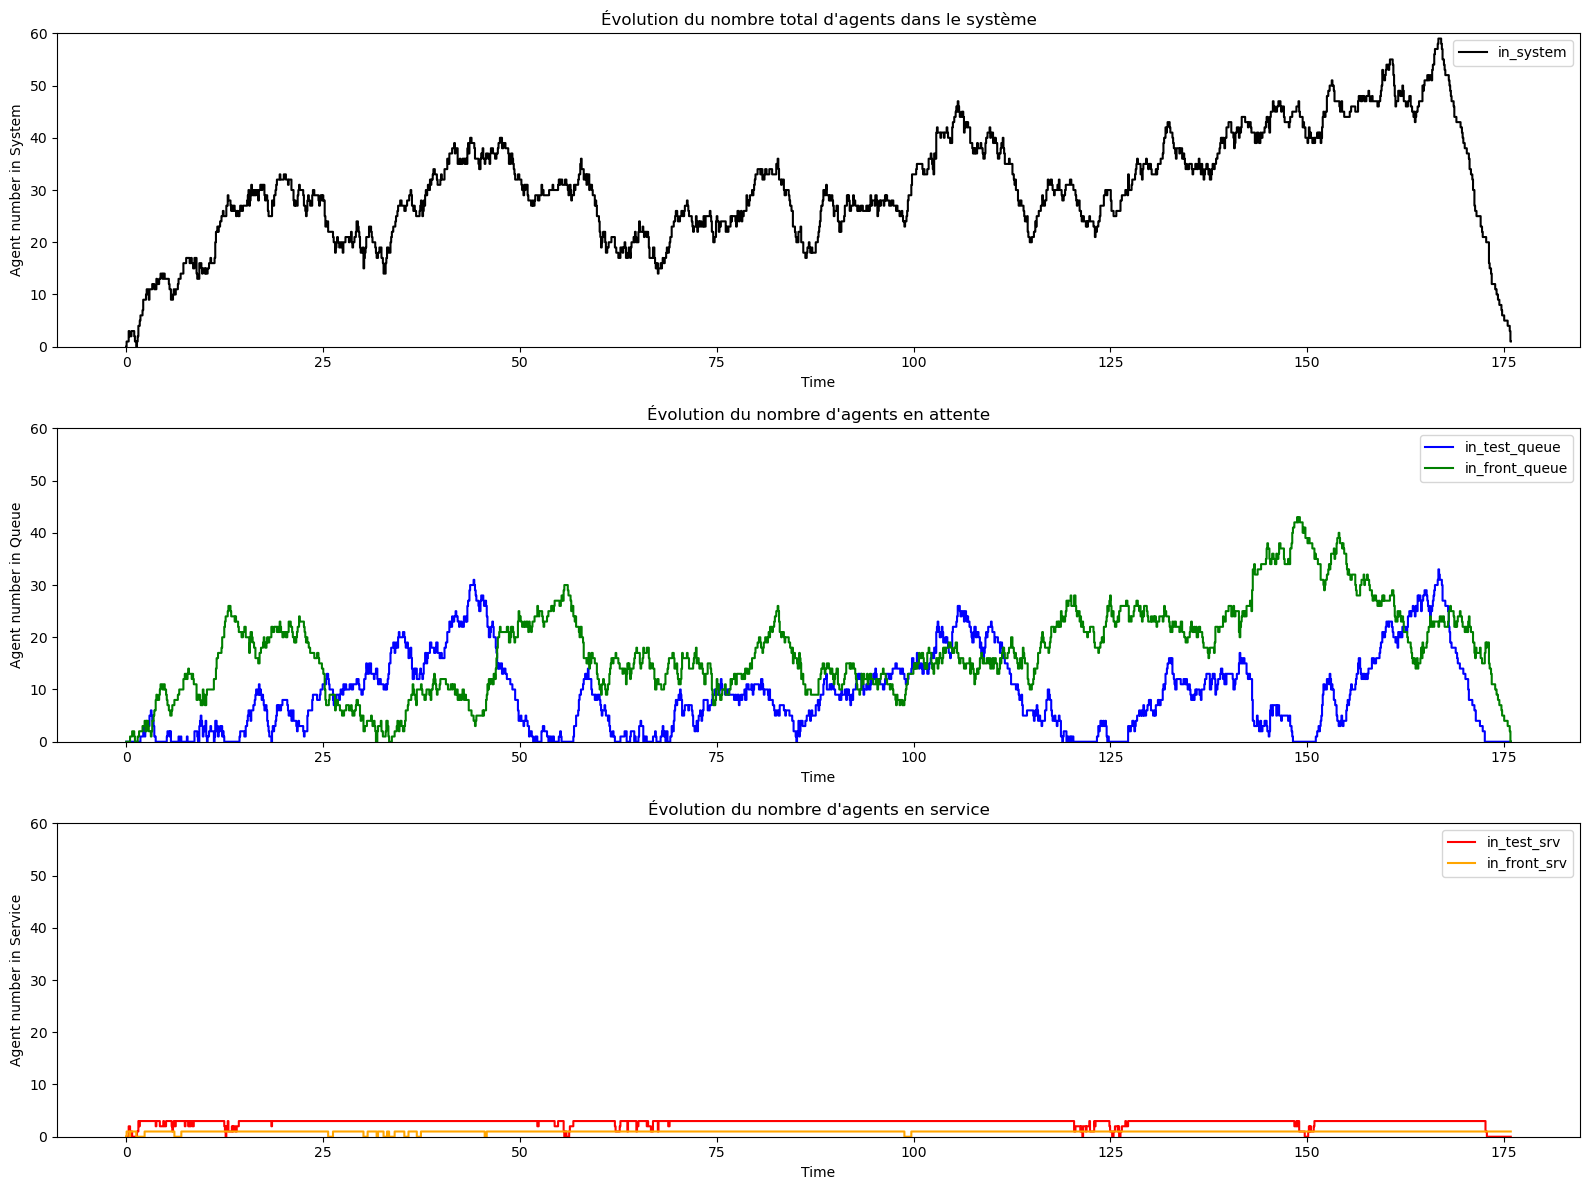

In [20]:
plot_bench(bench)

Le taux de charge étant de 1, le système n'est théoriquement pas stable. On observe bien une certaine instabilité du système dans les graphiques. Il est intéressant de noter que l'explosion n'est pas systématique, et avec un peu de chance on peut observer à la simulation une exécution qui semble "stable". Le système ne peut pas être considéré stable ici malgré cela.

### Synthèse
Si l'on souhaite avoir un bon fonctionnement du système (c'est-à-dire, avoir un système d'attente stable), on doit satisfaire les conditions suivantes sur les paramètres:
$$
\begin{cases}
\rho_1 = \frac{\lambda}{K * \mu_1} < 1 \\
\rho_2 = \frac{\lambda}{\mu_2} < 1
\end{cases}
$$


Intuitivement cela signifie que l'on doit avoir suffisamment de serveurs ($K$) et de vitesse de traitement suffisante ($\mu_1$ et $\mu_2$) pour supporter le rythme de push tags des étudiants ($\lambda$), et ainsi assurer une bonne expérience utilisateur.

## Cas avec files d'attentes finies
Dans ce deuxième cas, les files d'attentes ne sont plus infinies.
On rajoute donc deux paramètres a notre modélisation :
- $k_s$: taille max de la file d'attente de $F_1$
- $k_f$: taille max de la file d'attente de $F_2$

Nous nous attendons donc à ne plus voir d'"explosion" des files, mais à la place à avoir des augmentations du nombre d'agents rejetés.
Le système sera toujours "stable", mais en contre partie nous aurons des pertes d'agents en cas de saturation.

### Cas de référence
Nous effectuons une première simulation de référence avec les paramètres suivants:
- $ \lambda $ = 3
- $ \mu_1 $ = 2
- $ \mu_2 $ = 4
- $ K $ = 3
- $ k_s $ = 30
- $ k_f $ = 30

Ici le système est stable.

In [21]:
# Waiting system parameters
lambdaa = 3.
mu_1 = 2.
mu_2 = 4.
k = 4
k_s = 30
k_f = 30

arval_dist = lambda size : rng.exponential(1./lambdaa, size=size)
test_srv_dist = lambda : rng.exponential(1./mu_1)
front_srv_dist = lambda : rng.exponential(1./mu_2)

agent_nb = 1000

fifo_policy = lambda x: 0

waterfall = Waterfall(arval_dist,
                 test_srv_dist,
                 front_srv_dist,
                 k,
                 1,
                 test_queue_size=k_s,
                 front_queue_size=k_f,
                 test_policy=fifo_policy,
                 front_policy=fifo_policy,
                 test_size=agent_nb)

theo_f1 = theoretical_mmkc(lambdaa, mu_1, k, k_s)
theo_f2 = theoretical_mmkc(lambdaa, mu_2, 1, k_f)
theo_f1, theo_f2

({'mean_utilization_rate': 0.375,
  'p0': 0.22099447513817355,
  'p_blocking': 3.9205606069366524e-13,
  'mean_agents_waiting': 0.04475138120898747,
  'mean_agents_total': 1.5447513812083995,
  'lambda_eff': 2.999999999998824,
  'blocking_rate': 3.9205606069366524e-13,
  'mean_sojourn_time': 0.5149171270696683,
  'mean_waiting_time': 0.014917127069668338},
 {'mean_utilization_rate': 0.75,
  'p0': 0.25003348862725866,
  'p_blocking': 4.4651503011556456e-05,
  'mean_agents_waiting': 2.2458808988471843,
  'mean_agents_total': 2.9958474102199255,
  'lambda_eff': 2.999866045490965,
  'blocking_rate': 4.4651503011556456e-05,
  'mean_sojourn_time': 0.998660395094281,
  'mean_waiting_time': 0.7486603950942811})

In [22]:
waterfall.simulate()
bench, stats = waterfall.timeline()
stats

,value
mean_waiting_time_test,0.022336
mean_waiting_time_front,1.238858
mean_service_time_test,0.496206
mean_service_time_front,0.238739
mean_sojourn_time_test,0.518542
mean_sojourn_time_front,1.477596
mean_sojourn_time,1.996138
blocked_at_test,0.000000
blocked_at_front,0.000000
blocked_total,0.000000


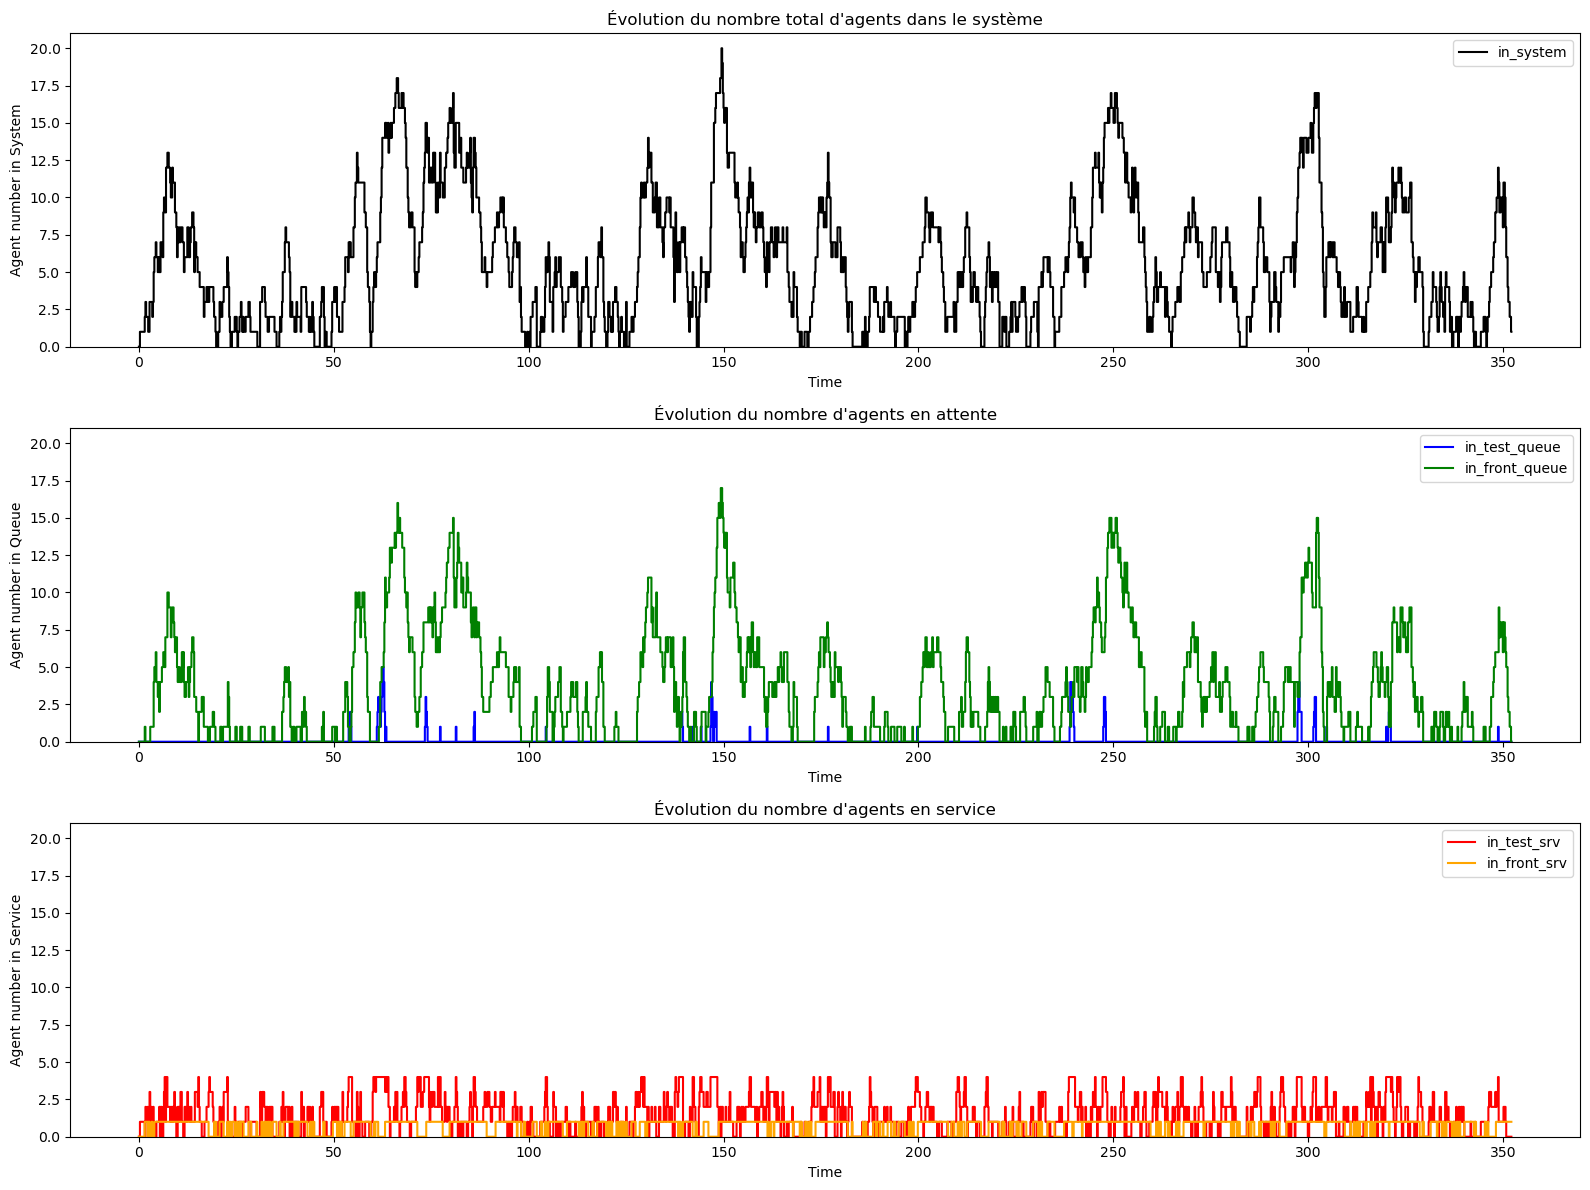

In [23]:
plot_bench(bench)

### Étude paramétrique sur le taux de refus
Nous changeons d'approche pour cette section et nous étudions désormais l'impact qu'ont les différents paramètres sur les métriques moyennnes renvoyées par notre simulation.

Pour chacun des paramètres nous allons étudier de façon empirique l'influence de celui-ci sur la proportion de refus.

In [32]:
def parametric_simulation(param_values, param_name, base_params):
    rows = []

    for val in param_values:
        params = base_params.copy()
        params[param_name] = val

        arval_dist = lambda size: rng.exponential(1./params["lambda"], size=size)
        test_srv_dist = lambda: rng.exponential(1./params["mu_1"])
        front_srv_dist = lambda: rng.exponential(1./params["mu_2"])

        waterfall = Waterfall(
            arval_dist,
            test_srv_dist,
            front_srv_dist,
            params["k"],
            1,
            test_queue_size=params["k_s"],
            front_queue_size=params["k_f"],
            test_policy=params["policy"],
            front_policy=params["policy"],
            test_size=params["agent_nb"]
        )

        

        waterfall.simulate()
        _, stats = waterfall.timeline()
        
        row = stats.stack()
        row.index = [f"{i}_{j}" for i, j in row.index]
        row[param_name] = val

        rows.append(row)

    return pd.DataFrame(rows)

#### Taux d'arrivé: λ

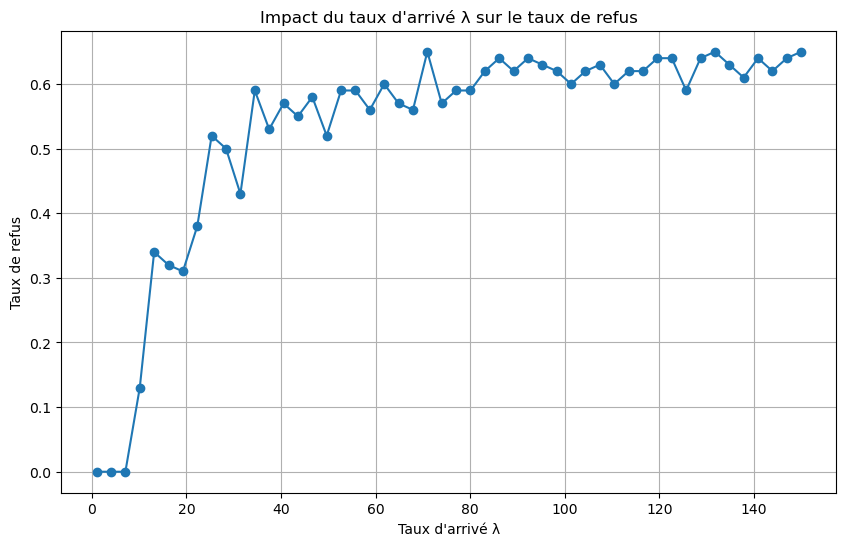

In [33]:
base_params = {
    "lambda": 3., 
    "mu_1": 2.,
    "mu_2": 4.,
    "k": 3,
    "k_s": 30,
    "k_f": 30,
    "agent_nb": 100,
    "policy": fifo_policy
}
lambda_values = np.linspace(1.0, 150.0, 50)

res = parametric_simulation(
    param_values=lambda_values,
    param_name="lambda",
    base_params=base_params
)

plt.figure(figsize=(10, 6))
plt.plot(res["lambda"], res["blocked_total_value"], marker='o')
plt.xlabel("Taux d'arrivé λ")
plt.ylabel("Taux de refus")
plt.title("Impact du taux d'arrivé λ sur le taux de refus")
plt.grid(True)
plt.show()

##### Conclusion
Une valeur de $\lambda$ plus élevée augmente le taux de refus de par la saturation du système d'attente.
On observe une augmentation drastqiue du taux de refus dès que $\lambda$ devient suffisamment élevé pour que le taux de charge dépasse 1.
Le taux de refus semble plafonner autour de 0.7 (70%) au maximum.

#### Taux de service de $F_1$: $\mu_1$

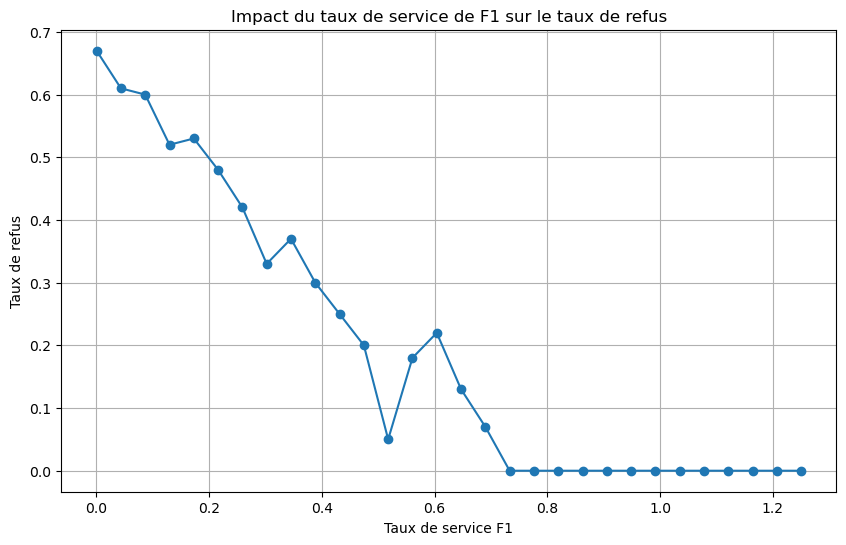

In [34]:
base_params = {
    "lambda": 3., 
    "mu_1": 2.,
    "mu_2": 4.,
    "k": 3,
    "k_s": 30,
    "k_f": 30,
    "agent_nb": 100,
    "policy": fifo_policy
}
mu_values = np.linspace(0.001, 1.25, 30)

res = parametric_simulation(
    param_values=mu_values,
    param_name="mu_1",
    base_params=base_params
)

plt.figure(figsize=(10, 6))
plt.plot(res["mu_1"], res["blocked_total_value"], marker='o')
plt.xlabel("Taux de service F1")
plt.ylabel("Taux de refus")
plt.title("Impact du taux de service de F1 sur le taux de refus")
plt.grid(True)
plt.show()

#### Taux de service de $F_2$: $\mu_2$

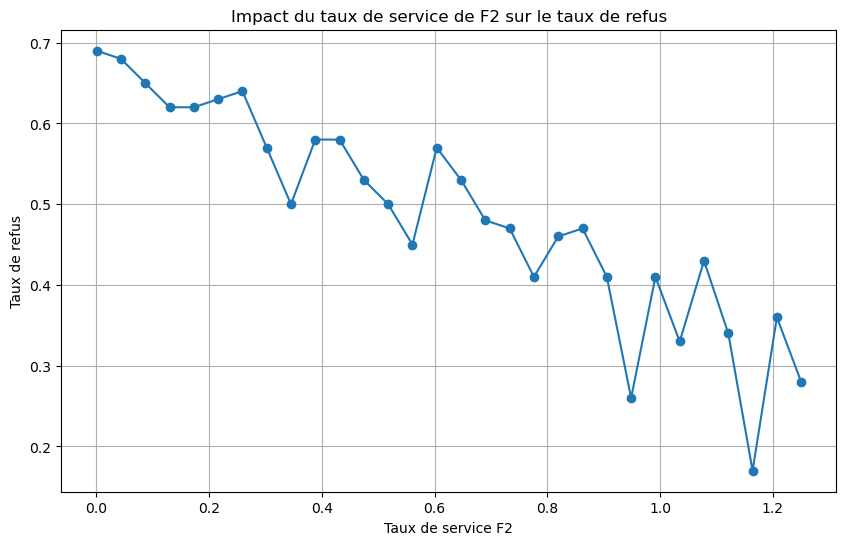

In [ ]:
base_params = {
    "lambda": 3., 
    "mu_1": 2.,
    "mu_2": 4.,
    "k": 3,
    "k_s": 30,
    "k_f": 30,
    "agent_nb": 100,
    "policy": fifo_policy
}
mu_values = np.linspace(0.001, 1.25, 30)

res = parametric_simulation(
    param_values=mu_values,
    param_name="mu_2",
    base_params=base_params
)

plt.figure(figsize=(10, 6))
plt.plot(res["mu_2"], res["blocked_total_value"], marker='o')
plt.xlabel("Taux de service F2")
plt.ylabel("Taux de refus")
plt.title("Impact du taux de service de F2 sur le taux de refus")
plt.grid(True)
plt.show()

#### Nombre de serveurs de $F_1$: $K$

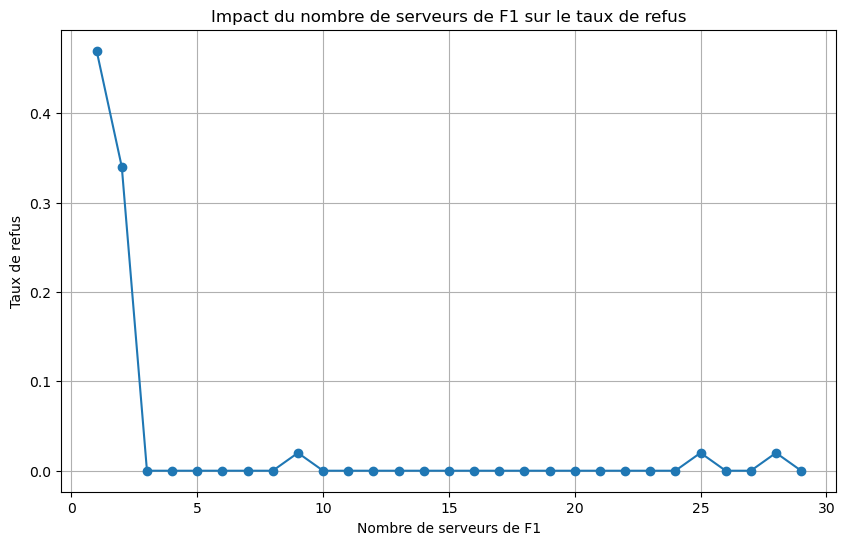

In [ ]:
base_params = {
    "lambda": 20., 
    "mu_1": 5.,
    "mu_2": 40.,
    "k": 3,
    "k_s": 30,
    "k_f": 30,
    "agent_nb": 100,
    "policy": fifo_policy
}
mu_values = [i for i in range(1, 30)]
#mu_values = np.linspace(1, 20, 20)

res = parametric_simulation(
    param_values=mu_values,
    param_name="k",
    base_params=base_params
)

plt.figure(figsize=(10, 6))
plt.plot(res["k"], res["blocked_total_value"], marker='o')
plt.xlabel("Nombre de serveurs de F1")
plt.ylabel("Taux de refus")
plt.title("Impact du nombre de serveurs de F1 sur le taux de refus")
plt.grid(True)
plt.show()

### Question 3: Analyse de l'impact des back-up

Il y a trois cas différents:
- pas de back-up -> page blanche si $F_2$ saturée
- back-up systématique -> si $F_2$ saturée alors on ne perd pas de données et on évite la page blanche
- back-up aléatoire -> si $F_2$ saturée, probabilité de ne pas perdre les données et donc d'éviter la page blanche

### Question 3.1 : Impact des back-up sur la proportion de pages blanches
#### Proportion de pages blanches sans back-up

In [62]:
lambdaa = 8.
mu_1 = 10.
mu_2 = 15.
k = 3
k_s = 10
k_f = 5

arval_dist = lambda size: rng.exponential(1./lambdaa, size=size)
test_srv_dist = lambda: rng.exponential(1./mu_1)
front_srv_dist = lambda: rng.exponential(1./mu_2)

waterfall_no_backup = Waterfall(
    arval_dist, test_srv_dist, front_srv_dist,
    k, 1,
    test_queue_size=k_s,
    front_queue_size=k_f,
    test_policy=fifo_policy,
    front_policy=fifo_policy,
    test_size=1000,
    backup=False
)

waterfall_no_backup.simulate()
_, stats_no_backup = waterfall_no_backup.timeline()
print(stats_no_backup)

                                value
mean_waiting_time_test       0.001274
mean_waiting_time_front      0.107811
mean_service_time_test       0.093564
mean_service_time_front      0.064580
mean_sojourn_time_test       0.094838
mean_sojourn_time_front      0.172391
mean_sojourn_time            0.265791
blocked_at_test              0.000000
blocked_at_front             0.023000
blocked_at_front_but_backup  0.000000
blocked_at_front_no_backup   0.023000
blocked_total                0.023000
test_busy_fraction           0.048951
front_busy_fraction          0.507493


#### Proportion pages blanches avec backup systématique

In [63]:
waterfall_backup = Waterfall(
    arval_dist, test_srv_dist, front_srv_dist,
    k, 1,
    test_queue_size=k_s,
    front_queue_size=k_f,
    test_policy=fifo_policy,
    front_policy=fifo_policy,
    test_size=1000,
    backup=True,
    backup_prob=1.0
)

waterfall_backup.simulate()
_, stats_backup = waterfall_backup.timeline()
print(stats_backup)

                                value
mean_waiting_time_test       0.000523
mean_waiting_time_front      0.100959
mean_service_time_test       0.096806
mean_service_time_front      0.062904
mean_sojourn_time_test       0.097329
mean_sojourn_time_front      0.163863
mean_sojourn_time            0.260241
blocked_at_test              0.000000
blocked_at_front             0.016000
blocked_at_front_but_backup  0.016000
blocked_at_front_no_backup   0.000000
blocked_total                0.016000
test_busy_fraction           0.029970
front_busy_fraction          0.503497


In [68]:
# Analyse détaillée de l'impact du backup
print("\n=== ANALYSE DE L'IMPACT DU BACKUP ===\n")

# Sans backup - utilisation des stats directes
nb_pages_blanches_sans = waterfall_no_backup.tops['blocked_front'].sum()
resultats_perdus_sans = nb_pages_blanches_sans  # Tous les blocked_front sont perdus sans backup

# Avec backup - utilisation des nouvelles colonnes
nb_pages_blanches_avec = waterfall_backup.tops['blocked_front'].sum()
resultats_recuperables = waterfall_backup.tops['blocked_front_but_backup'].sum()
resultats_perdus_avec = waterfall_backup.tops['blocked_front_no_backup'].sum()

print(f"SANS BACKUP:")
print(f"  - Pages blanches: {nb_pages_blanches_sans}")
print(f"  - Résultats définitivement perdus: {resultats_perdus_sans}")
print(f"  - Taux de perte: {resultats_perdus_sans/1000*100:.2f}%")

print(f"\nAVEC BACKUP SYSTÉMATIQUE:")
print(f"  - Pages blanches: {nb_pages_blanches_avec}")
print(f"  - Résultats sauvegardés (récupérables): {resultats_recuperables}")
print(f"  - Résultats définitivement perdus: {resultats_perdus_avec}")
print(f"  - Taux de perte réelle: {resultats_perdus_avec/1000*100:.2f}%")
print(f"  - Réduction de la perte: {(1 - resultats_perdus_avec/max(resultats_perdus_sans, 1))*100:.2f}%")


=== ANALYSE DE L'IMPACT DU BACKUP ===

SANS BACKUP:
  - Pages blanches: 23
  - Résultats définitivement perdus: 23
  - Taux de perte: 2.30%

AVEC BACKUP SYSTÉMATIQUE:
  - Pages blanches: 16
  - Résultats sauvegardés (récupérables): 16
  - Résultats définitivement perdus: 0
  - Taux de perte réelle: 0.00%
  - Réduction de la perte: 100.00%


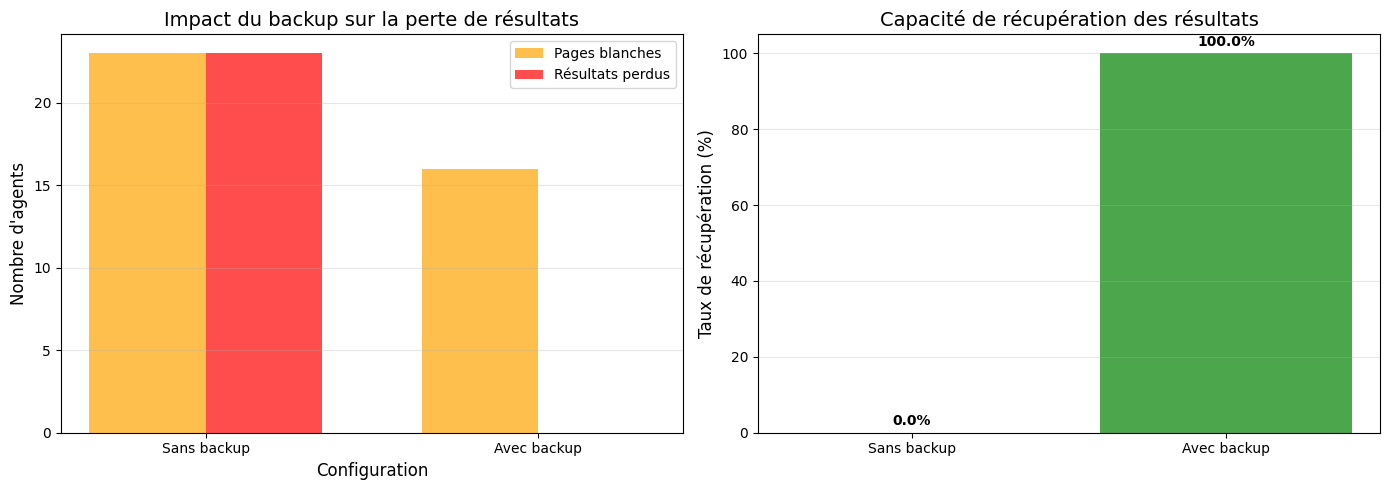

In [67]:
# Visualisation de l'impact du backup
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1: Comparaison pages blanches vs résultats perdus
categories = ['Sans backup', 'Avec backup']
pages_blanches_data = [nb_pages_blanches_sans, nb_pages_blanches_avec]
perdus_definitifs = [resultats_perdus_sans, resultats_perdus_avec]

x = np.arange(len(categories))
width = 0.35

axes[0].bar(x - width/2, pages_blanches_data, width, label='Pages blanches', color='orange', alpha=0.7)
axes[0].bar(x + width/2, perdus_definitifs, width, label='Résultats perdus', color='red', alpha=0.7)
axes[0].set_xlabel('Configuration', fontsize=12)
axes[0].set_ylabel('Nombre d\'agents', fontsize=12)
axes[0].set_title('Impact du backup sur la perte de résultats', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Graphique 2: Taux de récupération
recuperation_sans = 0
recuperation_avec = (resultats_recuperables / max(nb_pages_blanches_avec, 1)) * 100

axes[1].bar(['Sans backup', 'Avec backup'], 
           [recuperation_sans, recuperation_avec],
           color=['red', 'green'], alpha=0.7)
axes[1].set_ylabel('Taux de récupération (%)', fontsize=12)
axes[1].set_title('Capacité de récupération des résultats', fontsize=14)
axes[1].set_ylim([0, 105])
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate([recuperation_sans, recuperation_avec]):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### Synthèse Proportion de pages blanches

Le backup ne réduit pas le nombre de pages blanches, mais transforme ces pages blanches en résultats récupérables.

- **Pages blanches** : Surviennent quand la file d'attente 2 est pleine
- **Sans backup** : pages blanches = résultats définitivement perdus
- **Avec backup** : pages blanches sauvegardées et peuvent être récupérées ultérieurement

En termes d'expérience utilisateur ce serait comme se prendre une page blanche et refresh jusqu'à ce que l'agent qui a été backup soit réintroduit dans la file2 directement.

### Question 3.2 : Quels problèmes peuvent surgir avec cette solution ?

En faisant un back-up systématiquement avant l'envoi vers la seconde file, cela cause les problèmes suivants:

1. **Coût de stockage** :
   - Chaque résultat doit être stocké, ce qui consomme de l'espace disque

2. **Coût en temps** :
   - L'opération de backup ajoute de la latence au processus, ce qui nuit à l'expérience utilisateur par extension

3. **Complexité opérationnelle** :
   - Il faut trouver un système de gestion des back-ups (nettoyage des anciennes back-ups,..)

4. **Redondance** :
   - Beaucoup de résultats sauvegardés ne seront jamais consultés (si on fait une backup et que l'utilisateur n'a pas de page blanche il n'y a pas besoin de back-up)

Même si l'avantage de faire des back-up systématiquement est certain (plus de perte de données), des problèmes existent et justifient de trouver un équilibre entre trop faire de back-up et pas assez (il faudra lire le prochain chapitre pour découvrir cet équilibre.. stay tuned !)

### Analyse du backup aléatoire
TODO


### Conclusion sur le backup
TODO

## Conclusion
TODO